# Introduction

## Problem Statement

Predicting future weather conditions at Chicago Midway International Airport, encompassing metrics like average, maximum, and minimum temperatures, precipitation, and snowfall, is a vital deep learning problem. Accurate forecasts are crucial for everything from daily personal planning and agricultural decisions to ensuring safe and efficient air travel and effective disaster preparedness. Deep learning, particularly with architectures like LSTM, is uniquely suited to this challenge because it can uncover highly complex, non-linear, and long-range dependencies within the sequential and multi-variate data, which traditional models often miss. This allows for more nuanced and precise predictions in a dynamic environment.

## Data Description

The historical weather data is sourced from the National Centers for Environmental Information (NCEI) NOAA website, specifically for Chicago Midway International Airport, covering the period from 1997-05-01 to 2025-06-16. In this tabular dataset, each row represents a distinct day, providing observations for Date, TAVG (Average Temperature in Degrees Fahrenheit), TMAX (Maximum Temperature in Degrees Fahrenheit), TMIN (Minimum Temperature in Degrees Fahrenheit), PRCP (Precipitation in Inches), SNOW (Snowfall in Inches), and SNWD (Snow Depth in Inches). This forms a comprehensive time series, ideal for developing predictive models.

https://www.ncei.noaa.gov/access/past-weather/Chicago%20Midway%20Intl%20Airport


# Inputs

In [194]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import itertools
from tensorflow.keras.models import load_model

In [118]:
data = pd.read_csv('data.csv', skiprows=1)

In [119]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10274 entries, 0 to 10273
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       10274 non-null  object 
 1   TAVG (Degrees Fahrenheit)  2676 non-null   float64
 2   TMAX (Degrees Fahrenheit)  10256 non-null  float64
 3   TMIN (Degrees Fahrenheit)  10257 non-null  float64
 4   PRCP (Inches)              9918 non-null   float64
 5   SNOW (Inches)              417 non-null    float64
 6   SNWD (Inches)              1043 non-null   float64
dtypes: float64(6), object(1)
memory usage: 562.0+ KB


# EDA

## Data Type Munging

In [120]:
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values(by = 'Date')

## Missing Values

<Axes: >

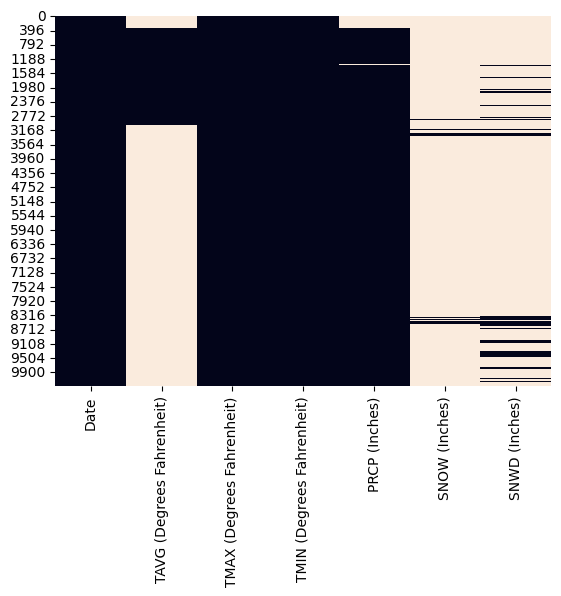

In [121]:
sns.heatmap(data.isnull(), cbar = False)

The heatmap shows a significant block of missing data for 'TAVG (Degrees Fahrenheit)' after the earliest part of the dataset, suggesting this measurement was not consistently recorded after a date. 

'SNOW (Inches)' and 'SNWD (Inches)' have substantial and scattered missing data throughout the entire period, which could imply either periods of no snow or inconsistent reporting. In contrast, 'TMAX (Degrees Fahrenheit)', 'TMIN (Degrees Fahrenheit)', and 'PRCP (Inches)' are largely complete, with only a few isolated missing entries, primarily towards the end of the dataset.

### Imputing missing TAVG by using an average between TMIN and TMAX

In [122]:
tavg_mask_nan = data['TAVG (Degrees Fahrenheit)'].isnull()
tmax_not_nan = data['TMAX (Degrees Fahrenheit)'].notnull()
tmin_not_nan = data['TMIN (Degrees Fahrenheit)'].notnull()


data.loc[tavg_mask_nan & tmax_not_nan & tmin_not_nan, 'TAVG (Degrees Fahrenheit)'] = \
(data.loc[tavg_mask_nan & tmax_not_nan & tmin_not_nan, 'TMAX (Degrees Fahrenheit)'] +
    data.loc[tavg_mask_nan & tmax_not_nan & tmin_not_nan, 'TMIN (Degrees Fahrenheit)']) / 2

In [123]:
data['TAVG (Degrees Fahrenheit)'].isnull().sum()

20

In [124]:
data = data[~data['TAVG (Degrees Fahrenheit)'].isnull()].reset_index(drop = True)

Still 20 days where Average and either Max or Min were null. Drop these days.

In [125]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10254 entries, 0 to 10253
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date                       10254 non-null  datetime64[ns]
 1   TAVG (Degrees Fahrenheit)  10254 non-null  float64       
 2   TMAX (Degrees Fahrenheit)  10251 non-null  float64       
 3   TMIN (Degrees Fahrenheit)  10251 non-null  float64       
 4   PRCP (Inches)              9905 non-null   float64       
 5   SNOW (Inches)              417 non-null    float64       
 6   SNWD (Inches)              1042 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 560.9 KB


In [126]:
data[(data['TMAX (Degrees Fahrenheit)'].isnull())|(data['TMIN (Degrees Fahrenheit)'].isnull())]

,Date,TAVG (Degrees Fahrenheit),TMAX (Degrees Fahrenheit),TMIN (Degrees Fahrenheit),PRCP (Inches),SNOW (Inches),SNWD (Inches)
365,1998-05-05,45.0,72.0,NaN,0.18,NaN,NaN
366,1998-05-06,45.0,73.0,NaN,0.47,NaN,NaN
1039,2000-03-10,53.0,NaN,28.0,0.00,NaN,NaN
1234,2000-09-21,69.0,NaN,47.0,0.01,NaN,NaN
1995,2002-10-24,34.0,NaN,NaN,0.01,NaN,NaN


In [127]:
data = data[~((data['TMAX (Degrees Fahrenheit)'].isnull())|(data['TMIN (Degrees Fahrenheit)'].isnull()))]

We will also remove the 5 days where MAX or MIN was missing. 

### Impute missing Snow and SNWD

In [128]:
data['SNOW (Inches)'] = data['SNOW (Inches)'].fillna(0)
data['SNWD (Inches)'] = data['SNWD (Inches)'].fillna(0)

For 'SNOW (Inches)' and 'SNWD (Inches)', it is often a reasonable and common assumption to treat missing values (NaNs) as zero. In meteorological datasets, if snowfall or snow depth isn't recorded for a day, it typically means there was no measurable snow or snow on the ground. This aligns with the sparse nature observed in the data and the real-world infrequency of significant snowfall.

In [129]:
data = data[~data['PRCP (Inches)'].isnull()]

## Visualization

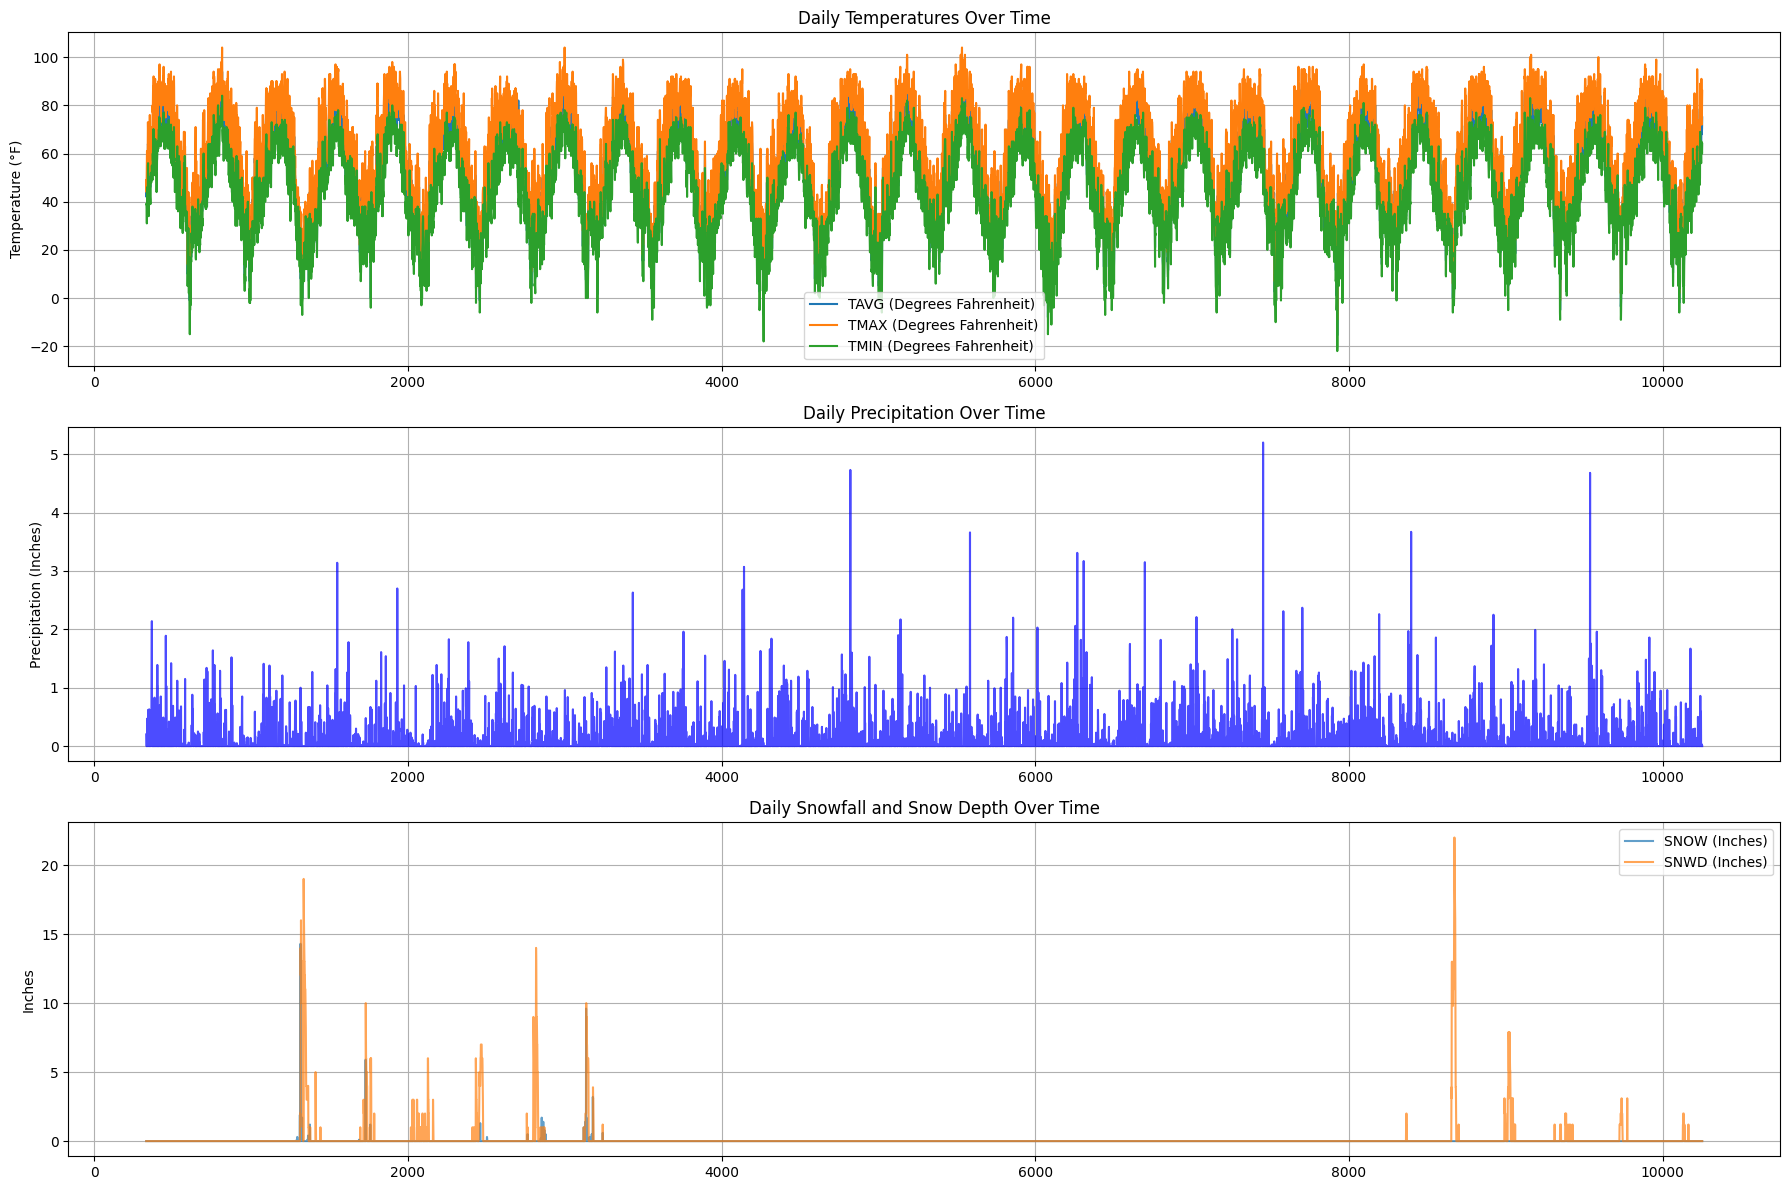

In [130]:
plt.figure(figsize=(18, 12))

plt.subplot(3, 1, 1)
data[['TAVG (Degrees Fahrenheit)', 'TMAX (Degrees Fahrenheit)', 'TMIN (Degrees Fahrenheit)']].plot(ax=plt.gca())
plt.title('Daily Temperatures Over Time')
plt.ylabel('Temperature (°F)')
plt.grid(True)

plt.subplot(3, 1, 2)
data['PRCP (Inches)'].plot(ax=plt.gca(), color='blue', alpha=0.7)
plt.title('Daily Precipitation Over Time')
plt.ylabel('Precipitation (Inches)')
plt.grid(True)

plt.subplot(3, 1, 3)
data[['SNOW (Inches)', 'SNWD (Inches)']].plot(ax=plt.gca(), alpha=0.7)
plt.title('Daily Snowfall and Snow Depth Over Time')
plt.ylabel('Inches')
plt.grid(True)

plt.tight_layout()

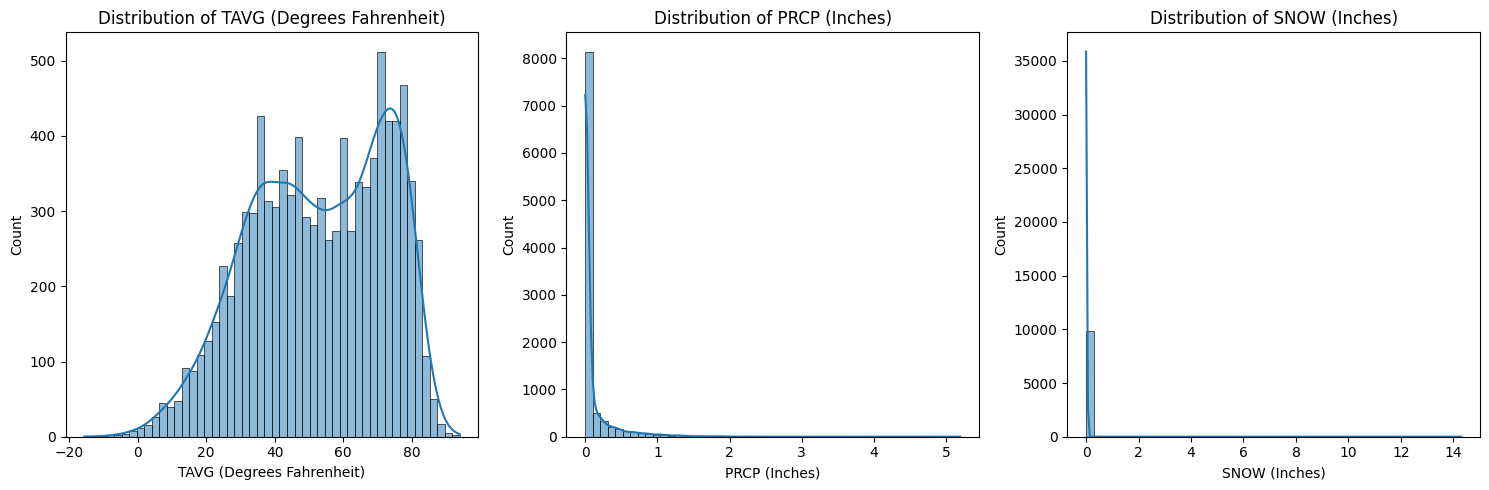

In [131]:
plt.figure(figsize=(15, 5))
for i, col in enumerate(['TAVG (Degrees Fahrenheit)', 'PRCP (Inches)', 'SNOW (Inches)']):
    plt.subplot(1, 3, i + 1)
    sns.histplot(data[col].dropna(), kde=True, bins=50)
    plt.title(f'Distribution of {col}')
plt.tight_layout()

Text(0.5, 1.0, 'Correlation Matrix of Weather Variables')

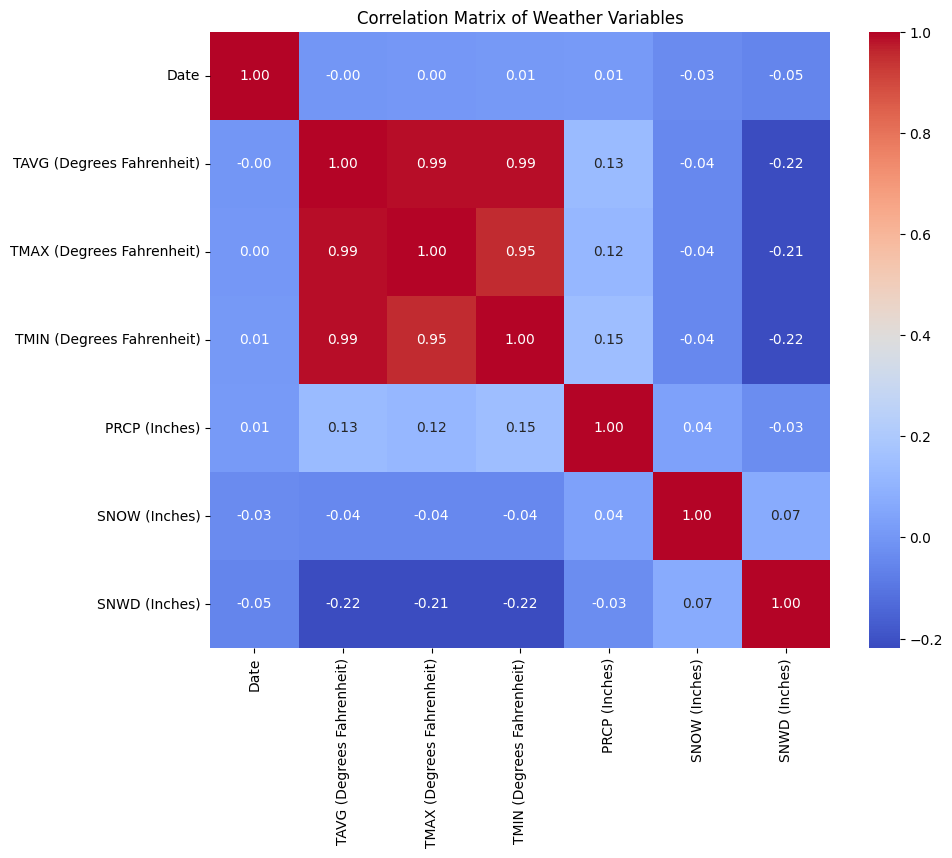

In [132]:
plt.figure(figsize=(10, 8))
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Weather Variables')

The provided visualizations offer key insights into the weather dataset. The "Daily Temperatures Over Time" plot clearly shows strong annual seasonality in temperature readings, with warm summers and cold winters, while "Daily Precipitation" and "Daily Snowfall and Snow Depth" plots reveal sporadic and highly variable events. Histograms further emphasize that precipitation and snowfall data are heavily skewed towards zero, indicating many days with no recorded events. Finally, the "Correlation Matrix of Weather Variables" heatmap confirms strong positive correlations among the temperature variables, but generally weaker relationships with precipitation and snow, highlighting their distinct patterns and potential independence.

## Feature Engineering

In [133]:
data.columns = ['Date','TAVG','TMAX','TMIN','PRCP','SNOW', 'SNWD']

### Lag Features

In [134]:
lag_days = [1, 2, 3, 5, 7] # Lag for 1, 2, 3, 5, 7 days ago
for col in ['TAVG', 'TMAX', 'TMIN', 'PRCP']:
    for lag in lag_days:
        data[f'{col}_lag_{lag}'] = data[col].shift(lag)
# Moving Averages (e.g., 5-day, 10-day, 20-day)
rolling_windows = [5, 10, 20]
for col in ['TAVG', 'TMAX', 'TMIN', 'PRCP']:
    for window in rolling_windows:
        data[f'{col}_rolling_mean_{window}d'] = data[col].rolling(window=window).mean()
        data[f'{col}_rolling_std_{window}d'] = data[col].rolling(window=window).std() # Standard deviation for volatility

for col in ['TAVG', 'TMAX', 'TMIN']:
    for window in rolling_windows:
        data[f'{col}_rolling_max_{window}d'] = data[col].rolling(window=window).max()
        data[f'{col}_rolling_min_{window}d'] = data[col].rolling(window=window).min()

### Temporal and Cyclical Features

In [135]:
data = data.set_index('Date')

In [136]:
data['year'] = data.index.year
data['month'] = data.index.month
data['day_of_week'] = data.index.dayofweek # Monday=0, Sunday=6
data['day_of_year'] = data.index.dayofyear
data['week_of_year'] = data.index.isocalendar().week.astype(int)
data['quarter'] = data.index.quarter

Lag features, like the previous day's temperature or precipitation, are crucial because they directly encode the sequential dependency inherent in time series data, allowing the deep learning model to learn how past observations influence future ones. Moving average (MA) features, such as a 5-day rolling average, help smooth out short-term noise and highlight underlying trends, providing a more stable and representative signal for the model to learn from.

In [137]:
# For seasonality in deep learning, consider sine/cosine transformations for cyclical features
data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)
data['day_of_year_sin'] = np.sin(2 * np.pi * data['day_of_year'] / 365)
data['day_of_year_cos'] = np.cos(2 * np.pi * data['day_of_year'] / 365)

Furthermore, sine and cosine transformations of cyclical features like 'month' or 'day of year' enable the deep learning model to perceive these as continuous cycles (e.g., December is followed by January), preventing it from inferring incorrect linear relationships and enhancing its ability to capture true seasonal patterns. These engineered features significantly enrich the dataset, offering the deep learning model a more comprehensive understanding of the complex temporal dynamics for improved prediction accuracy.

# Model Architecture

In [148]:
data.loc[:,'Target'] = data['TAVG'].shift(-1)
data = data.dropna()

In [197]:
X = data.drop('Target', axis = 1)
y = data['Target']

## Tran Test Val Split

In [198]:
train_size = 0.8 # 80% for training
val_test_size = 0.2 # 20% for validation and test combined

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=val_test_size, shuffle=False, random_state=1
)

test_size_of_temp = 0.5 # 50% of the temp set goes to test, 50% to validation

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=test_size_of_temp, shuffle=False, random_state= 1
)

print(f"\nX_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (7904, 78), y_train shape: (7904,)
X_val shape: (988, 78), y_val shape: (988,)
X_test shape: (988, 78), y_test shape: (988,)


## Scaling Features
- Very important for LSTM
- Standard Scalar
    -  This transforms data to have a mean of 0 and a standard deviation of 1. It's generally preferred when the data's distribution is approximately Gaussian (normal) or when you're dealing with outliers, as it doesn't bound the data to a specific range. For temperature data, this often works well.

In [199]:
features_to_scale = [col for col in X_train.columns if
                     not any(s in col for s in ['_sin', '_cos'])]

scaler = StandardScaler()
scaler.fit(X_train[features_to_scale])

X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

X_train_scaled[features_to_scale] = scaler.transform(X_train[features_to_scale])
X_val_scaled[features_to_scale] = scaler.transform(X_val[features_to_scale])
X_test_scaled[features_to_scale] = scaler.transform(X_test[features_to_scale])

## Base Model
- LSTM
    - 25 lookback days
    - One LSTM Unit 64
    - 50 Epochs, Batch size 32

In [200]:
def create_lstm_sequences(X, y, look_back):
    """
    Creates sequences from input features (X) and target (y) for LSTM.
    Each sample will consist of `look_back` consecutive days of features
    and the target for the day immediately following the sequence.
    """
    X_seq, y_seq = [], []
    # Ensure iteration is based on the length of X, considering the look_back window
    for i in range(len(X) - look_back):
        X_seq.append(X.iloc[i:(i + look_back)].values)
        y_seq.append(y.iloc[i + look_back]) # Target is the value after the look_back window
    return np.array(X_seq), np.array(y_seq)

In [201]:
look_back = 25 # Number of past days to consider for predicting the next day
num_features = X_train_scaled.shape[1] # Total number of features after scaling

X_train_lstm, y_train_lstm = create_lstm_sequences(X_train_scaled, y_train, look_back)
X_val_lstm, y_val_lstm = create_lstm_sequences(X_val_scaled, y_val, look_back)
X_test_lstm, y_test_lstm = create_lstm_sequences(X_test_scaled, y_test, look_back)

Epoch 1/50


/Users/tom/Desktop/my_env/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


247/247 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 776.8902 - val_loss: 84.4419
Epoch 2/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 83.9718 - val_loss: 72.9615
Epoch 3/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 69.5067 - val_loss: 65.4048
Epoch 4/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 64.5856 - val_loss: 72.9177
Epoch 5/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 63.4891 - val_loss: 63.2866
Epoch 6/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 59.8605 - val_loss: 62.8322
Epoch 7/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 58.2736 - val_loss: 65.0719
Epoch 8/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 60.7643 - val_loss: 70.0626
Epoch 9/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 58.8334 - val_loss: 63.7709
Epoch 10/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 55.8446 - val_loss: 67.6496
Epoch 11/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 55.8576 - val_loss: 66.2722


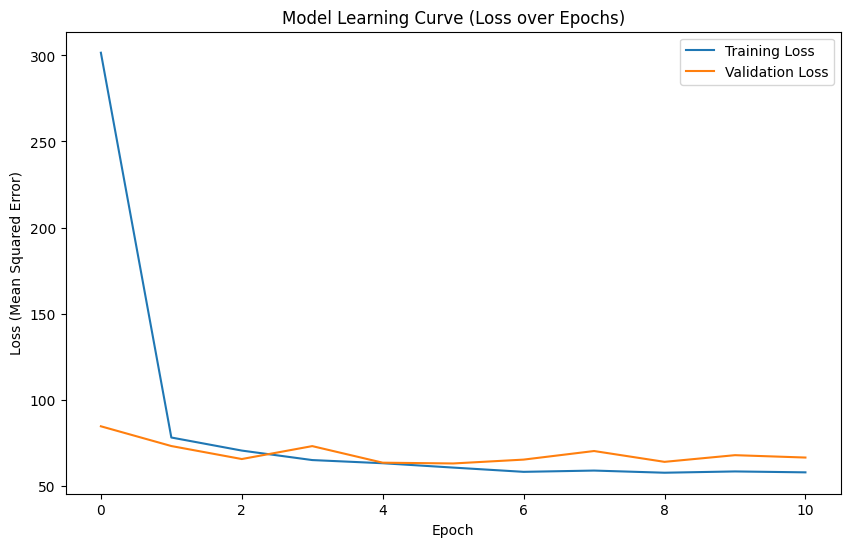

In [203]:
model = Sequential([
    LSTM(units=64, activation='relu', input_shape=(look_back, num_features)),
    Dense(units=1) # Output layer for predicting a single value (TAVGF)
])
model.compile(optimizer='adam', loss='mse')

early_stopping = EarlyStopping(
    monitor='val_loss', # Monitor validation loss
    patience=5,        # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True # Restores model weights from the epoch with the best value of the monitored quantity.
)

# Model checkpoint to save the best model during training
model_checkpoint = ModelCheckpoint(
    filepath='best_lstm_model.keras', # Filepath to save the model
    monitor='val_loss',             # Monitor validation loss
    save_best_only=True,            # Only save when val_loss improves
    mode='min',                     # Minimize val_loss
    verbose=0                       # Log when model is saved
)


history = model.fit(
    X_train_lstm, y_train_lstm,
    epochs=50,
    batch_size=32,
    validation_data=(X_val_lstm, y_val_lstm),
    callbacks=[early_stopping, model_checkpoint]
)

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Learning Curve (Loss over Epochs)')
plt.xlabel('Epoch')
plt.ylabel('Loss (Mean Squared Error)')
plt.legend()

The learning curves appear quite healthy with no / minimal indication of overfitting. This is not suprising, as the model only contins one LSTM layer and the early stopping is 1/10 total epochs.

In [204]:
# Make predictions for all sets
y_train_pred = model.predict(X_train_lstm).flatten()
y_val_pred = model.predict(X_val_lstm).flatten()
y_test_pred = model.predict(X_test_lstm).flatten()

# Calculate metrics for training set
train_mse = np.mean((y_train_lstm - y_train_pred)**2) 
train_mae = np.mean(np.abs(y_train_lstm - y_train_pred)) 
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train_lstm, y_train_pred) # R2 Score

print(f"\nTraining Results:")
print(f"  MSE: {train_mse:.4f}")
print(f"  RMSE: {train_rmse:.4f}")
print(f"  MAE: {train_mae:.4f}")
print(f"  R2 Score: {train_r2:.4f}")


# Calculate metrics for validation set
val_mse = np.mean((y_val_lstm - y_val_pred)**2) 
val_mae = np.mean(np.abs(y_val_lstm - y_val_pred)) 
val_rmse = np.sqrt(val_mse)
val_r2 = r2_score(y_val_lstm, y_val_pred) # R2 Score

print(f"\nValidation Results:")
print(f"  MSE: {val_mse:.4f}")
print(f"  RMSE: {val_rmse:.4f}")
print(f"  MAE: {val_mae:.4f}")
print(f"  R2 Score: {val_r2:.4f}")


# Calculate metrics for test set
test_mse = np.mean((y_test_lstm - y_test_pred)**2) 
test_mae = np.mean(np.abs(y_test_lstm - y_test_pred)) 
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test_lstm, y_test_pred) # R2 Score

print(f"\nTest Results (True Unseen Performance):")
print(f"  MSE: {test_mse:.4f}")
print(f"  RMSE: {test_rmse:.4f}")
print(f"  MAE: {test_mae:.4f}")
print(f"  R2 Score: {test_r2:.4f}")

247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Training Results:
  MSE: 58.2669
  RMSE: 7.6333
  MAE: 5.9301
  R2 Score: 0.8525

Validation Results:
  MSE: 62.8323
  RMSE: 7.9267
  MAE: 6.0616
  R2 Score: 0.8358

Test Results (True Unseen Performance):
  MSE: 76.8008
  RMSE: 8.7636
  MAE: 6.8236
  R2 Score: 0.7764


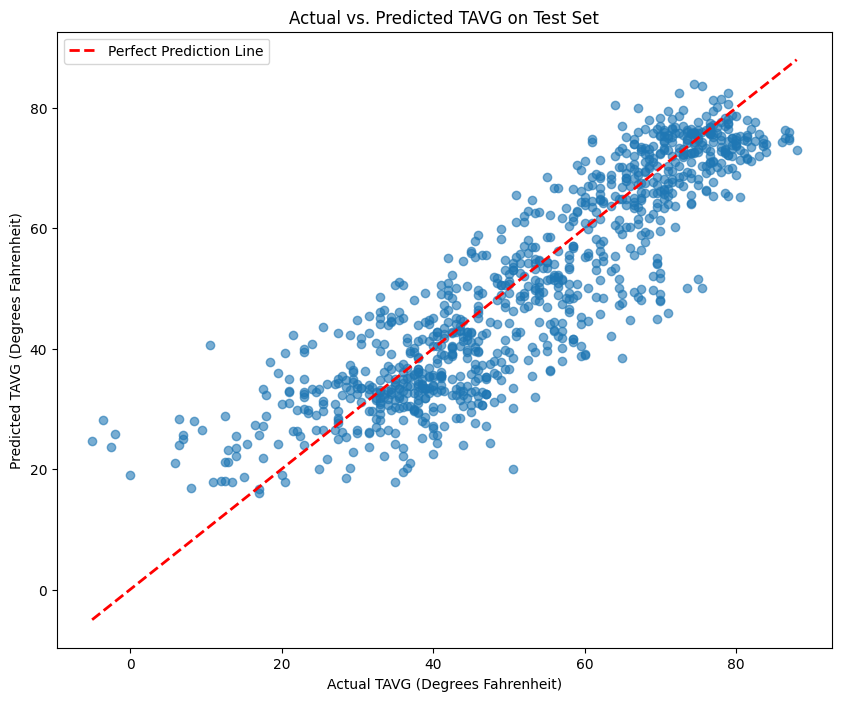

In [209]:
plt.figure(figsize=(10, 8))
plt.scatter(y_test_lstm, y_test_pred, alpha=0.6)
plt.plot([y_test_lstm.min(), y_test_lstm.max()], [y_test_lstm.min(), y_test_lstm.max()], 'r--', lw=2, label='Perfect Prediction Line')
plt.title('Actual vs. Predicted TAVG on Test Set')
plt.xlabel('Actual TAVG (Degrees Fahrenheit)')
plt.ylabel('Predicted TAVG (Degrees Fahrenheit)')
plt.legend()

The model shows reasonable performance with similar MSE, RMSE, and MAE values across training, validation, and test sets, indicating good generalization and no significant overfitting. Specifically, the test set's MAE of approximately 6.8 degrees Fahrenheit suggests the predictions are, on average, about 7 degrees off from the actual temperature. The R2 score of 0.78 on the test set indicates that the model explains about 78% of the variance in the target variable, which is a very strong starting point for complex weather prediction. To improve, future efforts could focus on hyperparameter tuning (e.g., more LSTM layers, different activation functions, dropout), exploring more advanced feature engineering, or incorporating additional external data sources (e.g., atmospheric pressure, wind patterns from other locations).

## GridSearch
- Lookback: 25, 50, 75
- Batch Size: 32, 64
- LSTM Unit: 32, 64

In [ ]:
look_backs = [25, 50, 75]
batch_sizes = [32, 64]
lstm_units = [32, 64]

# DataFrame to store results
results_df = pd.DataFrame(columns=[
    'Lookback', 'Batch Size', 'LSTM Units',
    'Train MSE', 'Train RMSE', 'Train MAE', 'Train R2',
    'Validation MSE', 'Validation RMSE', 'Validation MAE', 'Validation R2',
    'Test MSE', 'Test RMSE', 'Test MAE', 'Test R2'
])

In [210]:
for lb, bs, lu in itertools.product(look_backs, batch_sizes, lstm_units):
    num_features = X_train_scaled.shape[1] # Number of features remains constant
    X_train_lstm, y_train_lstm = create_lstm_sequences(X_train_scaled, y_train, lb)
    X_val_lstm, y_val_lstm = create_lstm_sequences(X_val_scaled, y_val, lb)
    X_test_lstm, y_test_lstm = create_lstm_sequences(X_test_scaled, y_test, lb)

    model = Sequential([
        LSTM(units=lu, activation='relu', input_shape=(lb, num_features)),
        Dense(units=1) # Output layer for predicting a single value (TAVGF)
    ])
    model.compile(optimizer='adam', loss='mse')

    # Define Early Stopping and Model Checkpoint callbacks
    model_filepath = f'best_lstm_model_lb{lb}_bs{bs}_lu{lu}.keras'
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
    model_checkpoint = ModelCheckpoint(
        filepath=model_filepath,
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=0
    )

    # Model Training
    history = model.fit(
        X_train_lstm, y_train_lstm,
        epochs=50,
        batch_size=bs, # Use current batch size
        validation_data=(X_val_lstm, y_val_lstm),
        callbacks=[early_stopping, model_checkpoint],
        verbose=0 # Set verbose to 0 to keep output clean during grid search
    )

    y_train_pred = model.predict(X_train_lstm).flatten()
    y_val_pred = model.predict(X_val_lstm).flatten()
    y_test_pred = model.predict(X_test_lstm).flatten()

    train_mse = mean_squared_error(y_train_lstm, y_train_pred)
    train_mae = mean_absolute_error(y_train_lstm, y_train_pred)
    train_rmse = np.sqrt(train_mse)
    train_r2 = r2_score(y_train_lstm, y_train_pred)

    val_mse = mean_squared_error(y_val_lstm, y_val_pred)
    val_mae = mean_absolute_error(y_val_lstm, y_val_pred)
    val_rmse = np.sqrt(val_mse)
    val_r2 = r2_score(y_val_lstm, y_val_pred)

    test_mse = mean_squared_error(y_test_lstm, y_test_pred)
    test_mae = mean_absolute_error(y_test_lstm, y_test_pred)
    test_rmse = np.sqrt(test_mse)
    test_r2 = r2_score(y_test_lstm, y_test_pred)

    # Store results in DataFrame
    results_df.loc[len(results_df)] = [
        lb, bs, lu,
        train_mse, train_rmse, train_mae, train_r2,
        val_mse, val_rmse, val_mae, val_r2,
        test_mse, test_rmse, test_mae, test_r2
    ]

    print(f"  Train: MSE={train_mse:.2f}, RMSE={train_rmse:.2f}, MAE={train_mae:.2f}, R2={train_r2:.2f}")
    print(f"  Val:   MSE={val_mse:.2f}, RMSE={val_rmse:.2f}, MAE={val_mae:.2f}, R2={val_r2:.2f}")
    print(f"  Test:  MSE={test_mse:.2f}, RMSE={test_rmse:.2f}, MAE={test_mae:.2f}, R2={test_r2:.2f}")

/Users/tom/Desktop/my_env/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
  Train: MSE=72.45, RMSE=8.51, MAE=6.74, R2=0.82
  Val:   MSE=76.16, RMSE=8.73, MAE=6.85, R2=0.80
  Test:  MSE=85.61, RMSE=9.25, MAE=7.43, R2=0.75


/Users/tom/Desktop/my_env/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
  Train: MSE=54.67, RMSE=7.39, MAE=5.78, R2=0.86
  Val:   MSE=60.41, RMSE=7.77, MAE=6.02, R2=0.84
  Test:  MSE=84.53, RMSE=9.19, MAE=7.08, R2=0.75


/Users/tom/Desktop/my_env/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
  Train: MSE=61.55, RMSE=7.85, MAE=6.19, R2=0.84
  Val:   MSE=75.17, RMSE=8.67, MAE=6.70, R2=0.80
  Test:  MSE=85.52, RMSE=9.25, MAE=7.24, R2=0.75


/Users/tom/Desktop/my_env/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
  Train: MSE=63.94, RMSE=8.00, MAE=6.25, R2=0.84
  Val:   MSE=63.06, RMSE=7.94, MAE=6.21, R2=0.84
  Test:  MSE=79.98, RMSE=8.94, MAE=6.99, R2=0.77


/Users/tom/Desktop/my_env/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
  Train: MSE=628.23, RMSE=25.06, MAE=19.04, R2=-0.59
  Val:   MSE=520.06, RMSE=22.80, MAE=16.82, R2=-0.39
  Test:  MSE=585.54, RMSE=24.20, MAE=18.90, R2=-0.69


/Users/tom/Desktop/my_env/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


246/246 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Train: MSE=385.78, RMSE=19.64, MAE=14.69, R2=0.02
  Val:   MSE=374.14, RMSE=19.34, MAE=13.94, R2=-0.00
  Test:  MSE=471.96, RMSE=21.72, MAE=16.18, R2=-0.36


/Users/tom/Desktop/my_env/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


246/246 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Train: MSE=704.53, RMSE=26.54, MAE=20.50, R2=-0.78
  Val:   MSE=822.19, RMSE=28.67, MAE=21.91, R2=-1.20
  Test:  MSE=920.72, RMSE=30.34, MAE=24.36, R2=-1.66


/Users/tom/Desktop/my_env/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


246/246 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
  Train: MSE=212.66, RMSE=14.58, MAE=10.52, R2=0.46
  Val:   MSE=209.27, RMSE=14.47, MAE=10.51, R2=0.44
  Test:  MSE=219.93, RMSE=14.83, MAE=10.95, R2=0.37


/Users/tom/Desktop/my_env/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


245/245 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
  Train: MSE=739.37, RMSE=27.19, MAE=22.10, R2=-0.87
  Val:   MSE=827.21, RMSE=28.76, MAE=23.03, R2=-1.19
  Test:  MSE=1008.00, RMSE=31.75, MAE=27.22, R2=-1.89


/Users/tom/Desktop/my_env/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


245/245 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
  Train: MSE=149.48, RMSE=12.23, MAE=8.89, R2=0.62
  Val:   MSE=191.68, RMSE=13.84, MAE=9.68, R2=0.49
  Test:  MSE=260.52, RMSE=16.14, MAE=11.17, R2=0.25


/Users/tom/Desktop/my_env/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


245/245 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
  Train: MSE=33045.10, RMSE=181.78, MAE=86.43, R2=-82.68
  Val:   MSE=3458.48, RMSE=58.81, MAE=55.72, R2=-8.17
  Test:  MSE=14922.07, RMSE=122.16, MAE=73.82, R2=-41.72


/Users/tom/Desktop/my_env/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


245/245 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
  Train: MSE=63717007.19, RMSE=7982.29, MAE=3071.95, R2=-161346.22
  Val:   MSE=45385884.16, RMSE=6736.90, MAE=2598.61, R2=-120272.22
  Test:  MSE=58407591.32, RMSE=7642.49, MAE=2759.41, R2=-167211.29


In [211]:
results_df

,Lookback,Batch Size,LSTM Units,Train MSE,Train RMSE,Train MAE,Train R2,Validation MSE,Validation RMSE,Validation MAE,Validation R2,Test MSE,Test RMSE,Test MAE,Test R2
0,25.0,32.0,32.0,7.245258e+01,8.511908,6.742313,0.816588,7.616084e+01,8.727018,6.853916,0.800957,8.561320e+01,9.252740,7.434387,0.750745
1,25.0,32.0,64.0,5.467485e+01,7.394244,5.775411,0.861592,6.041276e+01,7.772564,6.023935,0.842114,8.452702e+01,9.193858,7.080148,0.753907
2,25.0,64.0,32.0,6.155019e+01,7.845393,6.188391,0.844187,7.517423e+01,8.670307,6.702589,0.803535,8.552181e+01,9.247801,7.237499,0.751011
3,25.0,64.0,64.0,6.394449e+01,7.996530,6.252277,0.838126,6.305766e+01,7.940886,6.206574,0.835201,7.998001e+01,8.943154,6.989101,0.767146
4,50.0,32.0,32.0,6.282312e+02,25.064540,19.039790,-0.588294,5.200579e+02,22.804777,16.816260,-0.391577,5.855409e+02,24.197952,18.897646,-0.690525
5,50.0,32.0,64.0,3.857792e+02,19.641262,14.690098,0.024673,3.741408e+02,19.342718,13.938884,-0.001130,4.719561e+02,21.724551,16.182785,-0.362593
6,50.0,64.0,32.0,7.045296e+02,26.542976,20.495451,-0.781192,8.221891e+02,28.673839,21.909136,-1.200023,9.207161e+02,30.343304,24.363930,-1.658215
7,50.0,64.0,64.0,2.126650e+02,14.583037,10.519364,0.462340,2.092680e+02,14.466099,10.509214,0.440038,2.199257e+02,14.829891,10.949997,0.365049
8,75.0,32.0,32.0,7.393706e+02,27.191369,22.101218,-0.872269,8.272056e+02,28.761182,23.027752,-1.192106,1.007998e+03,31.748978,27.218884,-1.885748
9,75.0,32.0,64.0,1.494802e+02,12.226208,8.887253,0.621479,1.916802e+02,13.844861,9.677912,0.492045,2.605153e+02,16.140487,11.173866,0.254183


The grid search results clearly illustrate the impact of hyperparameter choices on the LSTM model's performance for weather prediction. The best configuration, achieving the lowest test RMSE of 9.19 and MAE of 7.08, utilized a lookback of 25 days, a batch size of 32, and 64 LSTM units. This optimal model also exhibited excellent training metrics (lowest train RMSE 7.39, MAE 5.78), indicating strong learning and generalization.

Conversely, configurations with a lookback of 75 days, especially those with 64 LSTM units, showed the most significant performance degradation, yielding extremely high error metrics and large negative R2 scores. This indicates severe underfitting or model instability, suggesting that a very long lookback period might overwhelm the model or dilute meaningful patterns in this dataset. The vast difference in performance between the best and worst runs highlights the critical role of thoughtful hyperparameter tuning in time series forecasting with deep learning.

Increasing the lookback period drastically reduces the number of available sequences for the LSTM model. For instance, with a 75-day lookback, the model needs 75 past days of data to make a single prediction, meaning you lose 75 data points from the start of the dataset for sequence creation. If the resulting training or validation sets become too small, the validation loss can become unstable or less representative, causing EarlyStopping to halt training prematurely or restore weights from a suboptimal local minimum. This leads to the observed high errors (e.g., test RMSE up to 31.75 and large negative R2 values), indicating the model fails to learn meaningful patterns and generalizes poorly when provided with an excessive history or insufficient number of resulting samples for robust training.